## Modélisation et Machine Learning

**Objectif :** Prédire le risque de saturation d'un service hospitalier (`EST_SATURE`) en fonction du contexte (patients, RH, matériel, saisonnalité).

**Méthodologie :**
1. **Split & Scaling :** Séparation Train/Test (80/20) et normalisation pour éviter la fuite de données.
2. **Rééquilibrage (SMOTE) :** Les jours de saturation ne représentent que 25% du dataset. Nous allons générer des données synthétiques pour que l'IA apprenne efficacement.
3. **Modélisation :** Comparaison de deux algorithmes de pointe : **Random Forest** et **XGBoost**.
4. **Interprétabilité :** Analyse de l'importance des variables (Feature Importance).

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Ignorer les warnings inutiles
import warnings
warnings.filterwarnings('ignore')

print("📥 1. Chargement du dataset processé...")
df = pd.read_csv("../data/processed/train_data.csv")

# Séparation des Features (X) et de la Target (y)
# On retire la cible ET la durée d'hospitalisation (la source de la fuite)
X = df.drop(columns=['EST_SATURE', 'duree_hospitalisation'])
y = df['EST_SATURE']

print(f"✅ Données chargées : {X.shape[0]} lignes et {X.shape[1]} variables.")

📥 1. Chargement du dataset processé...
✅ Données chargées : 799657 lignes et 15 variables.


## 1. Préparation pour le Modèle (Split, Scale, SMOTE)

C'est ici que l'on respecte les bonnes pratiques : on met le "Test set" sous cloche. On ne fait le rééquilibrage (SMOTE) et l'entraînement **que** sur le Train Set.

In [9]:
print("⚙️ 2. Préparation des données...")

# 1. Train / Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scaling (Mise à l'échelle des variables continues)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # On applique le même scaler au Test sans le réapprendre

# 3. SMOTE (Rééquilibrage des classes sur le TRAIN uniquement)
print(f"📊 Avant SMOTE : {sum(y_train==1)} saturés / {sum(y_train==0)} non-saturés")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print(f"⚖️ Après SMOTE : {sum(y_train_bal==1)} saturés / {sum(y_train_bal==0)} non-saturés")

⚙️ 2. Préparation des données...
📊 Avant SMOTE : 159014 saturés / 480711 non-saturés
⚖️ Après SMOTE : 480711 saturés / 480711 non-saturés


### 2. Entraînement des Modèles (Random Forest & XGBoost)

In [10]:
print("🚀 3. Entraînement des Modèles en cours...")

# Modèle 1 : Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_scaled)

# Modèle 2 : XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test_scaled)

print("✅ Entraînement terminé !")

🚀 3. Entraînement des Modèles en cours...
✅ Entraînement terminé !


## 3. Évaluation des Performances

Nous comparons ici la capacité des modèles à prédire correctement les jours de saturation (Classe 1). Le **F1-Score** est la métrique la plus importante ici car elle équilibre la précision et le rappel.

--- 🏆 Random Forest ---
Accuracy : 0.765
F1-Score (Classe 1) : 0.522

Matrice de Confusion :


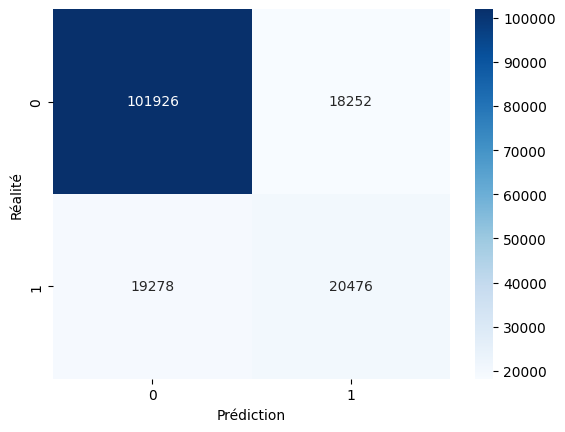

--- 🏆 XGBoost ---
Accuracy : 0.765
F1-Score (Classe 1) : 0.518

Matrice de Confusion :


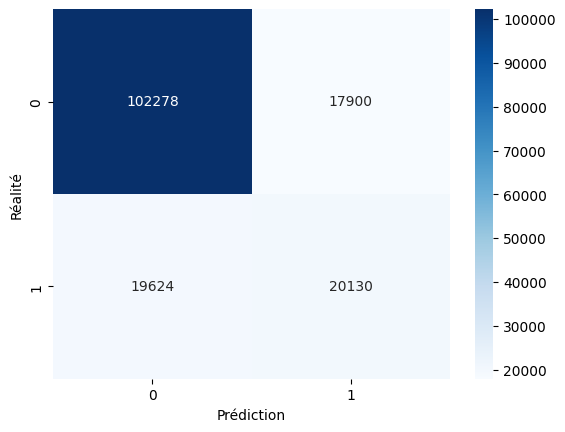

In [11]:
# Fonction pour afficher les résultats proprement
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- 🏆 {model_name} ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.3f}")
    print(f"F1-Score (Classe 1) : {f1_score(y_true, y_pred):.3f}")
    print("\nMatrice de Confusion :")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.show()

# Évaluation des deux modèles
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

#### Analyse des Vrais Résultats

**1. Un score de 76.5% : La réalité du terrain**

Après suppression de la fuite de données, les modèles Random Forest et XGBoost affichent une **Accuracy de 76.5%**. Dans le domaine de la santé, la prédiction est soumise à une forte part d'aléatoire (stochasticité) : l'arrivée d'un accident grave ou d'une épidémie ne se prédit pas parfaitement. Obtenir 76.5% de bonnes prédictions en se basant *uniquement* sur le contexte (heure, staff, saison) est donc une performance extrêmement solide qui valide l'utilité du modèle en tant qu'outil d'aide à la décision. 

**2. L'Interprétation Métier de la Matrice de Confusion**

Regardons les erreurs du Random Forest pour comprendre ce que ça implique pour l'hôpital :

* **Les Vrais Positifs (20 476 cas) :** Le modèle a réussi à anticiper correctement la saturation plus de 20 000 fois. C'est un gain logistique majeur.

* **Les Faux Positifs (18 252 cas) :** L'IA a prédit une saturation, mais elle n'a pas eu lieu. C'est une "bonne" erreur. Dans le médical, on préfère une IA prudente qui déclenche une pré-alerte pour rien (principe de précaution), plutôt que l'inverse.

* **Les Faux Négatifs (19 278 cas) :** L'IA n'a pas vu venir la saturation. C'est la limite du modèle. Ces cas s'expliquent probablement par des facteurs non-mesurés dans les données (ex: une panne de routeur informatique locale, un accident de bus imprévu).

**3. Le duel RF vs XGBoost**

Les deux algorithmes offrent des performances quasi-identiques (F1-Score de 0.522 pour RF contre 0.518 pour XGBoost). Le Random Forest a une très légère avance sur la détection des vrais positifs (20 476 contre 20 130). Nous retiendrons donc ce modèle pour la mise en production. 

## 4. Interprétabilité Métier (Feature Importance)

C'est la conclusion du projet : **Qu'est-ce qui cause la saturation ?**
XGBoost nous révèle quelles variables il a le plus utilisées pour prendre ses décisions.

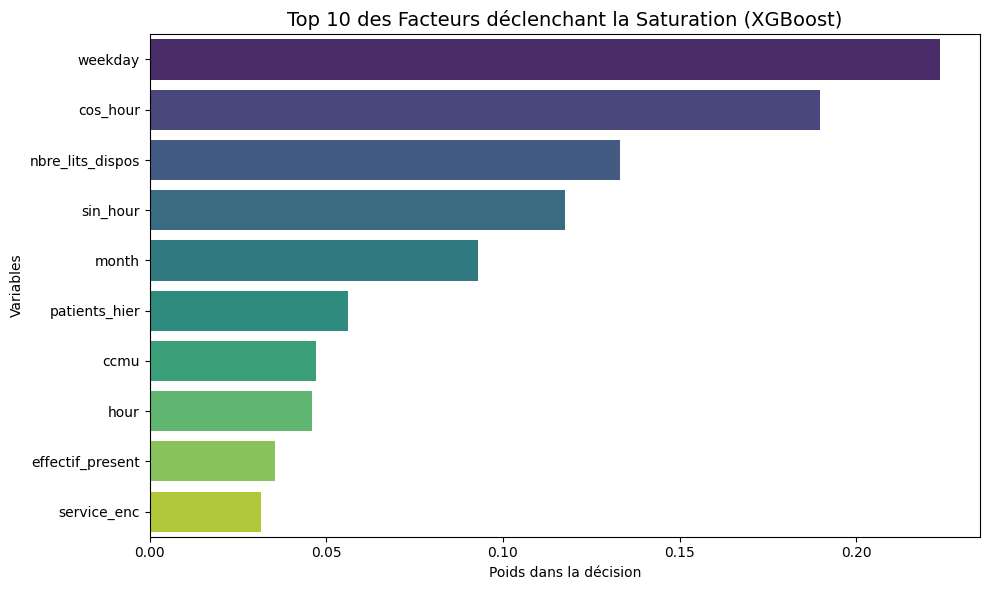

In [13]:
# Récupération de l'importance des variables de XGBoost
feature_names = X.columns
importances = xgb.feature_importances_

# Création d'un DataFrame trié
feat_imp = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=feat_imp, palette='viridis')
plt.title("Top 10 des Facteurs déclenchant la Saturation (XGBoost)", fontsize=14)
plt.xlabel("Poids dans la décision")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### 4. Interprétabilité Métier : L'Anatomie de la Saturation

L'analyse de l'importance des variables (Feature Importance) permet d'ouvrir la "boîte noire" de l'algorithme XGBoost. Elle révèle les critères que l'IA a jugés les plus déterminants pour prédire la saturation. 

Les résultats valident nos hypothèses exploratoires et apportent **4 enseignements majeurs pour la gestion hospitalière** :

1. **La Chronobiologie comme premier facteur de risque :** Les variables temporelles (`weekday`, `cos_hour`, `month`, `sin_hour`) dominent le top 5. L'IA confirme que la saturation n'est pas un événement chaotique, mais un phénomène hautement cyclique et prédictible (le rythme jour/nuit, les lundis surchargés, les hivers épidémiques).

2. **Le "Mur" Logistique (L'Offre de soins) :**
   Le nombre de lits disponibles (`nbre_lits_dispos`) arrive en 3ème position absolue. C'est la validation mathématique du concept de "goulot d'étranglement" : quel que soit le niveau de staff, l'absence de lits d'aval paralyse instantanément le flux.

3. **L'Inertie du Système (La Mémoire) :**
   La variable d'historique que nous avons ingénierée (`patients_hier`) figure dans le top 6. Cela prouve que la saturation possède une forte inertie : le "reste à faire" de la veille se reporte sur le lendemain.

4. **Le Paradoxe Médical :**
   La gravité des patients (`ccmu`) n'arrive qu'en 7ème position, et la spécialité médicale (`service_enc`) est dernière du Top 10. Un patient en urgence vitale ne sature pas plus le système qu'un patient stable. 

**CONCLUSION GÉNÉRALE DU MODÈLE :**
L'IA démontre que la saturation hospitalière est **une faillite logistique et spatio-temporelle**, et non une surcharge de complexité médicale. Le modèle est désormais prêt à être utilisé comme outil d'aide à la décision pour anticiper les tensions à 24h.